Global settings and import

In [4]:


from matplotlib import pyplot as plt

outputs=['RESULT_InclinationBeltDirection__deg_',
       'RESULT_Inclination90ToBeltDirection__deg_']


Columns after low variance filter and domain knowledge

In [ ]:
with open("data\columns_domain.txt", "r") as file:
    columns = file.read().strip().split(",")

Import, NAN filter

In [5]:
from utils import load_raw
importer=load_raw.DataFrameImporter()
importer.load("Data","data/Data Thesis.csv")
#importer.NOK_Cleaning("100k",True)
importer.NAN_Cleaning("Data")
df = importer.get_dataframe("Data")
df.head()





,ID,RESULT_InclinationBeltDirection__deg_,RESULT_Inclination90ToBeltDirection__deg_
0,0001 25 033,0.11,-0.11
1,0002 25 033,0.03,-0.09
2,0003 25 033,0.08,-0.07
3,0004 25 033,0.04,-0.21
4,0005 25 033,0.01,-0.14


Outliers filter

In [6]:
from preprocess.outlier_filter import filter
df_filtered=filter(df,outputs)
inclination_toBD_original=df_filtered[outputs[0]]


c:\svn\python projects\thesis project\src\preprocess\outlier_filter.py:31: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  z_score = pd.concat([z_score, z_score_i])  # Append the result to z_score


Comparison of original and filtered data

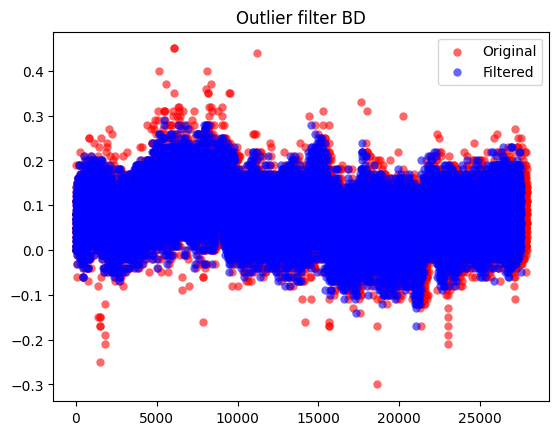

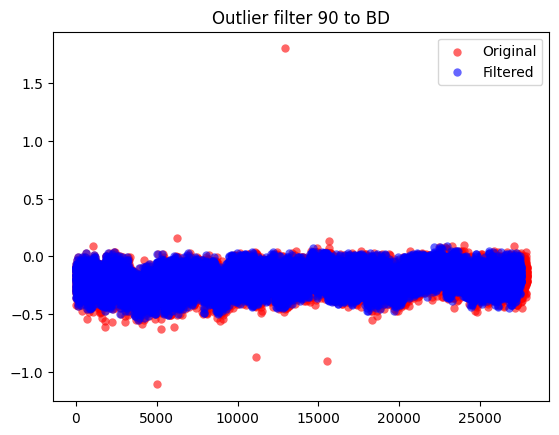

In [7]:
plt.scatter(range(len(df[outputs[0]])),df[outputs[0]].values,label="Original",alpha=0.6,linewidths=0,color='red')
plt.scatter(range(len(df_filtered[outputs[0]])),df_filtered[outputs[0]].values, label="Filtered",alpha=0.6,linewidths=0,color='blue')
plt.title("Outlier filter BD")
plt.legend()
plt.show()
plt.scatter(range(len(df[outputs[1]])),df[outputs[1]].values,label="Original",alpha=0.6,linewidths=0,color='red')
plt.scatter(range(len(df_filtered[outputs[1]])),df_filtered[outputs[1]].values, label="Filtered",alpha=0.6,linewidths=0,color='blue')
plt.title("Outlier filter 90 to BD")
plt.legend()
plt.show()

EDA

In [8]:
from ydata_profiling import ProfileReport
import sweetviz as sv
profile = ProfileReport(df_filtered, title="Ydata Profiling Report")
profile.to_file("eda_report\ydata_EDA.html")
report = sv.analyze(df_filtered, target_feat=outputs[0])
report.show_html('eda_report\sweetviz_EDA.html')


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

                                             |          | [  0%]   00:00 -> (? left)

Report eda_report\sweetviz_EDA.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
import dtale
import dtale.global_state as global_state
global_state.set_chart_settings({'scatter_points': 200000, '3d_points': 40000})
dtale.show(df_filtered)

Normalization and transformation

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler().fit(inclination_toBD_original.values.reshape(-1, 1))

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(inclination_toBD_original.values.reshape(-1, 1))


In [10]:
inclination_toBD_scaled=scaler.transform(inclination_toBD_original.values.reshape(-1, 1)).flatten()


StatTest

Skewness: 0.01740724746577313
Shapiro-Wilk Test Statistic:=0.9971, p-value=0.0000
Data is not normally distributed
Kolmogorov-Smirnov Test: Statistic=0.5945, p-value=0.0000
Data is NOT normal (Reject H0)


c:\SVN\Python projects\Thesis Project\.venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


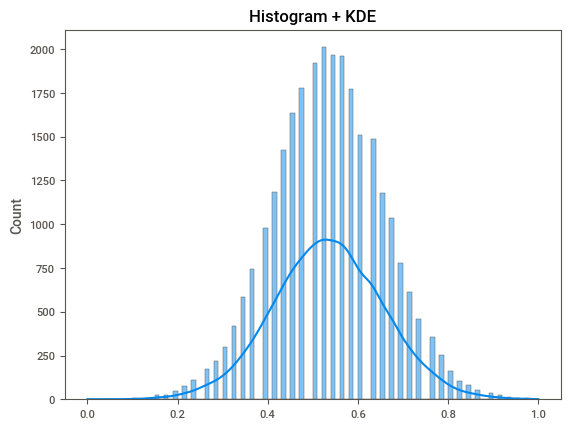

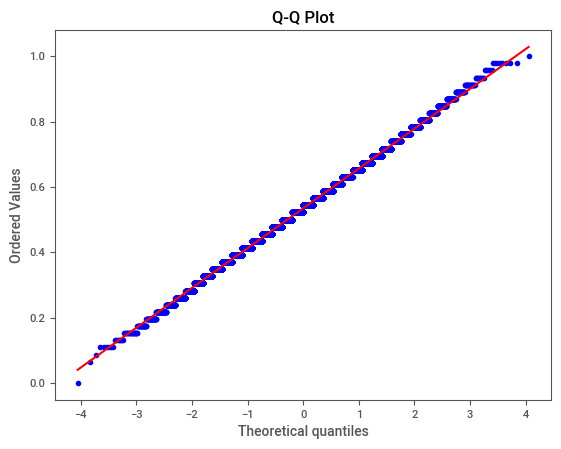

ADF Statistic: -7.445622602104686
p-value: 5.848964213415003e-11
Used Lags: 47
Number of Observations: 27480

Interpretation:
The p-value is 0.0000, which is less than 0.05.
This means the series is likely stationary.


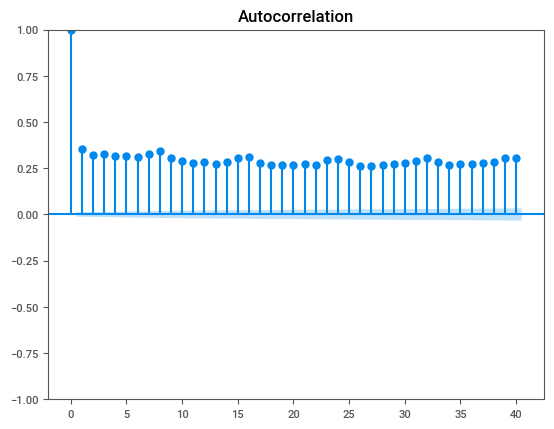

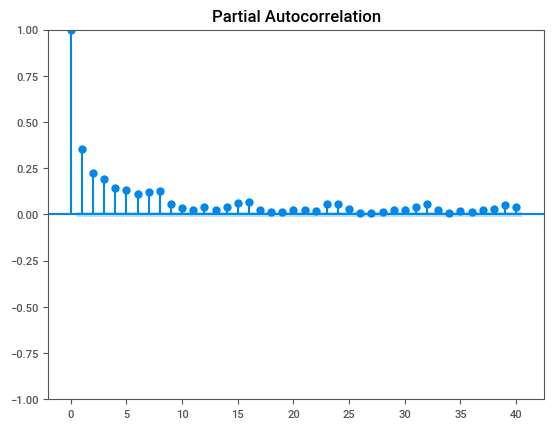

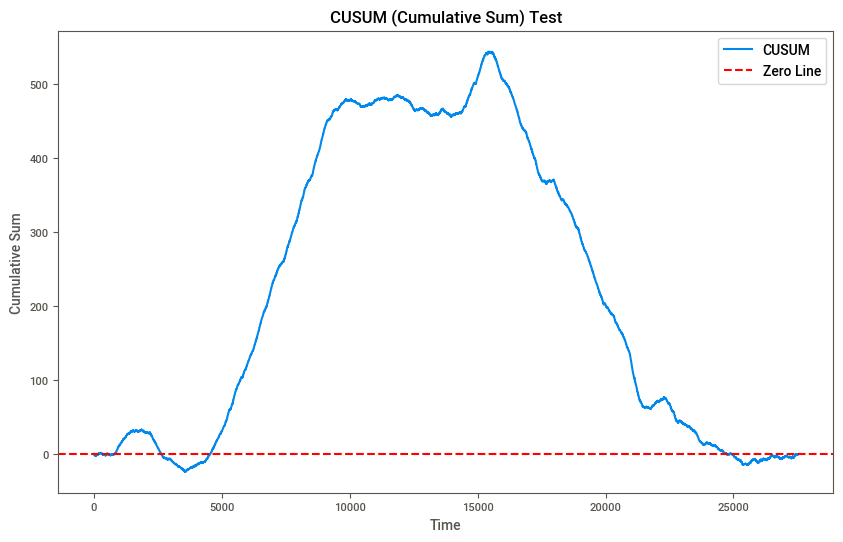

In [11]:
from evaluation import statests
import importlib
importlib.reload(statests)
statests.test_autoregression(inclination_toBD_scaled)
#statests.breakpoints(inclination_toBD_original_scaled)


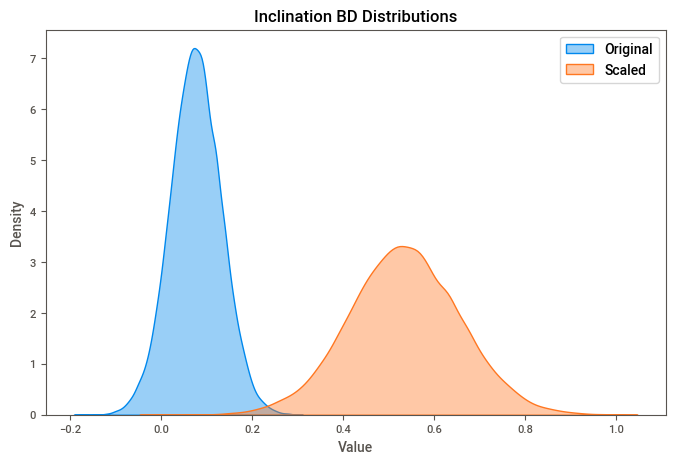

In [12]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.kdeplot(inclination_toBD_original, label="Original", fill=True, alpha=0.4)
sns.kdeplot(inclination_toBD_scaled, label="Scaled", fill=True, alpha=0.4)
#plt.hist(inclination_toBD_original,bins=46,alpha=0.5,label="Original")
#plt.hist(inclination_toBD_original_scaled,bins=46,alpha=0.5, label="Scaled")
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Inclination BD Distributions')
plt.legend()
plt.show()

Smoothing

In [13]:

from preprocess import smoothing
import pandas as pd


#methods=['MA', 'Gaussian', 'Wavelet', 'RTS']
datasmoothing = smoothing.DataSmoothing(inclination_toBD_scaled, methods=['RTS'], max_lag=50)
smoothed=datasmoothing.get_smoothed_data()



Smoothing tests

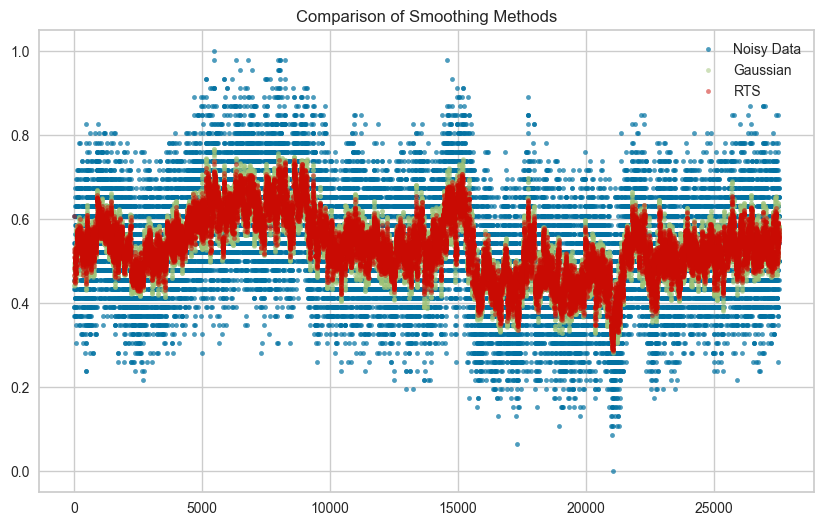

                            Gaussian       RTS
MSE                         0.008187  0.008849
Autocorrelation (Noisy)     0.356106  0.356106
Autocorrelation (Smoothed)  0.994730  0.990383
Best Lag (Noisy)            1.000000  1.000000
Best Lag (Smoothed)         1.000000  1.000000
Standard Deviation Ratio    0.625180  0.586003
Variance Ratio              0.390850  0.343399
Time                        0.000761  1.540857


In [15]:
denoised_data_test = pd.DataFrame(datasmoothing.compare_smoothing_methods())
print(denoised_data_test)

In [ ]:

inclination_toBD_sc_tr_sm=smoothed['Noisy Data']
#statests.test_autoregression(inclination_toBD_sc_tr_sm)

In [ ]:
inclination_toBD_sc_GA=smoothed['Gaussian Filter']
#statests.test_autoregression(inclination_toBD_sc_tr_sm)

In [14]:
inclination_toBD_sc_RTS=smoothed['RTS Smoothing']
#statests.test_autoregression(inclination_toBD_sc_RTS)


In [17]:
import joblib

# Save any variable (model, scaler, numpy array, dict, etc.)
#joblib.dump(inclination_toBD_sc_GA, 'tmp/output1_smoothed_gaus.pkl')
joblib.dump(inclination_toBD_sc_RTS, 'tmp/output1_smoothed_RTS.pkl')
#joblib.dump(inclination_toBD_original.values, 'tmp/output1_or.pkl')




['tmp/output1_smoothed_RTS.pkl']

Regression

In [15]:
from regression import regression_pycaret as rpc
import importlib
importlib.reload(rpc)
regression=rpc.RegressionPyCaret(inclination_toBD_sc_RTS)
regression.create_lagged_features()
regression.setup_and_train_models(['lr', 'ridge', 'lightgbm','rf']) #['lr', 'ridge', 'lightgbm', 'rf']
regression_results=regression.predict()
regression_results=pd.DataFrame(regression_results)

Splitting data before training models...


,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(21926, 101)"
4,Transformed data shape,"(21926, 101)"
5,Transformed train set shape,"(16445, 101)"
6,Transformed test set shape,"(5481, 101)"
7,Numeric features,100


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0267,0.0012,0.0338,0.3439,0.0216,0.0480,1.5450
ridge,Ridge Regression,0.0267,0.0012,0.0338,0.3438,0.0216,0.0480,0.5020
lightgbm,Light Gradient Boosting Machine,0.0285,0.0013,0.0357,0.2926,0.0229,0.0518,0.8380
rf,Random Forest Regressor,0.0286,0.0013,0.0358,0.2879,0.0230,0.0521,18.7050


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0278,0.0012,0.0348,0.2762,0.0229,0.0540


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.0278,0.0012,0.0349,0.2751,0.0229,0.0541


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0291,0.0014,0.0368,0.1936,0.0242,0.0566


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0290,0.0014,0.0370,0.1830,0.0243,0.0565


Linear regression
  Metric       Value
0    MSE    0.001215
1    MAE    0.027849
2   RMSE    0.034860
3     R2    0.275114
4   MAPE    5.407688
5  SMAPE    5.357192
6    SAE  152.696213


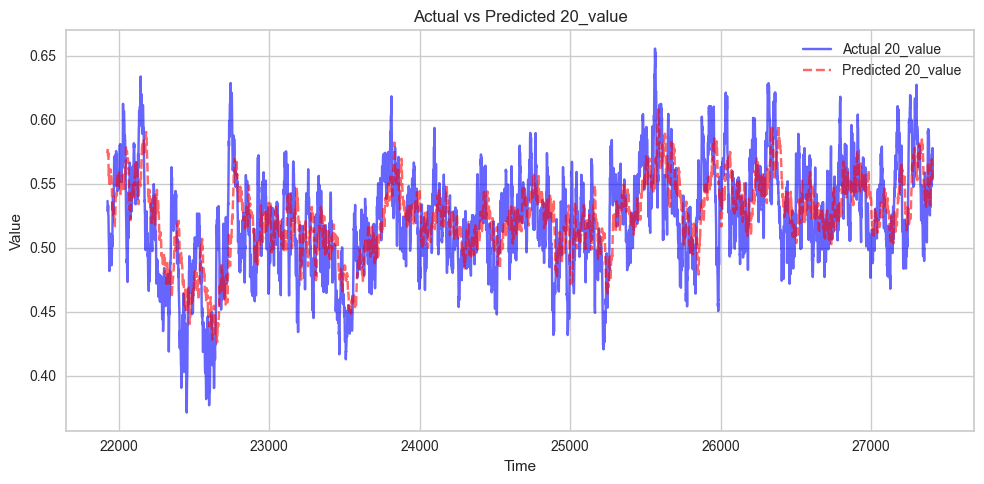

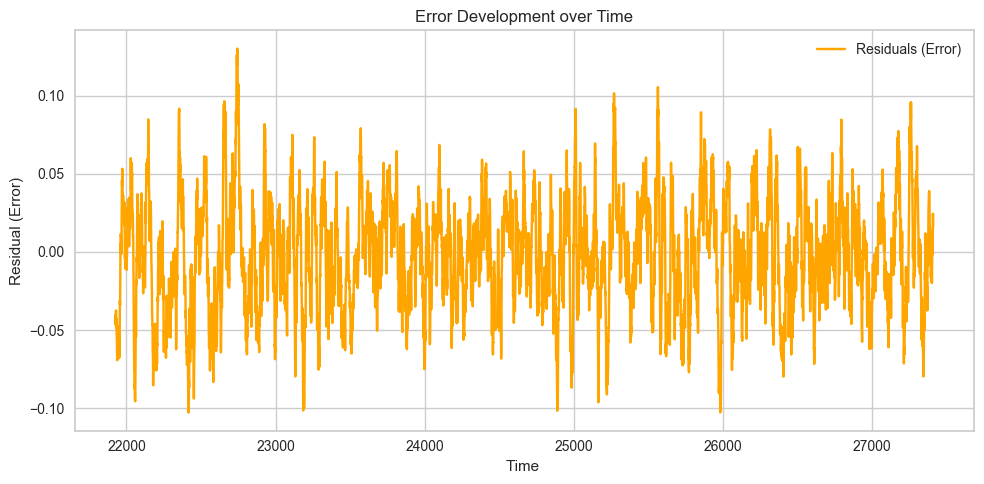

Ridge regression
  Metric       Value
0    MSE    0.001213
1    MAE    0.027822
2   RMSE    0.034833
3     R2    0.276233
4   MAPE    5.401535
5  SMAPE    5.351775
6    SAE  152.546112


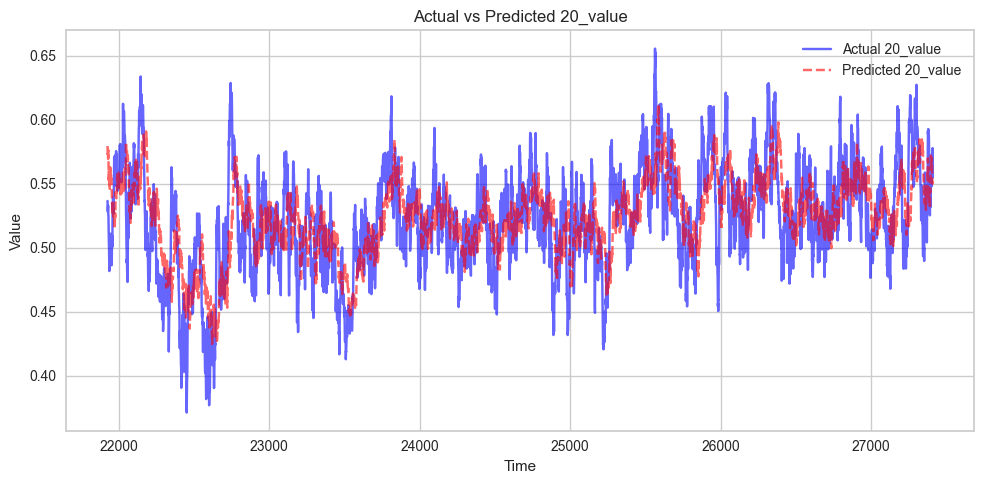

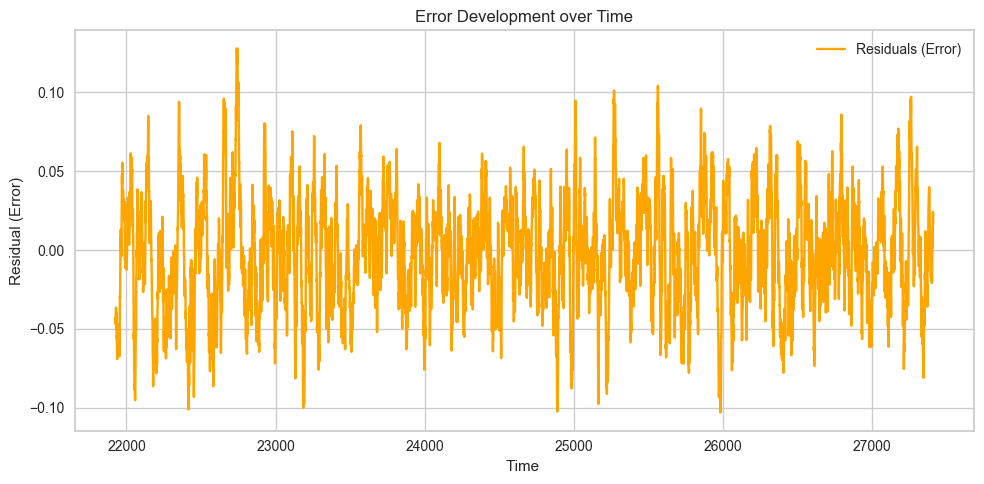

Random Forest regression
  Metric       Value
0    MSE    0.001370
1    MAE    0.029031
2   RMSE    0.037010
3     R2    0.182951
4   MAPE    5.650657
5  SMAPE    5.577488
6    SAE  159.175634


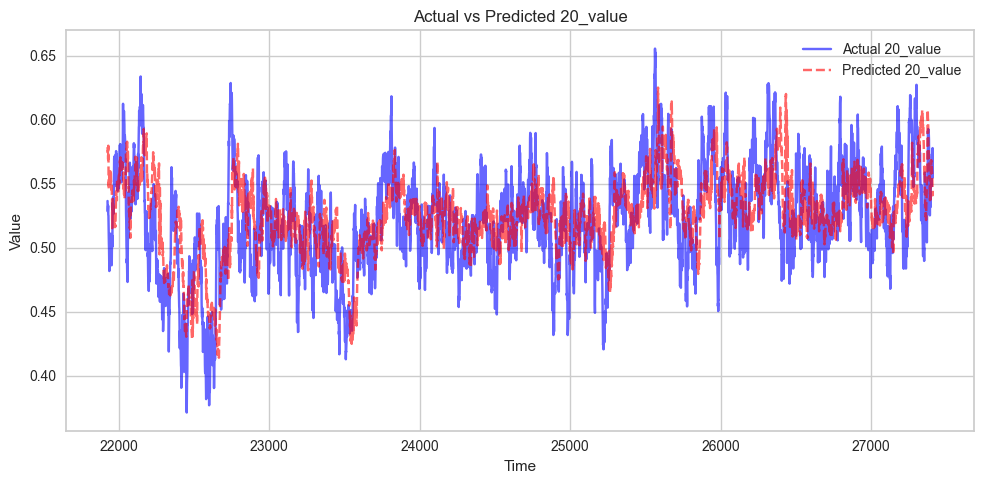

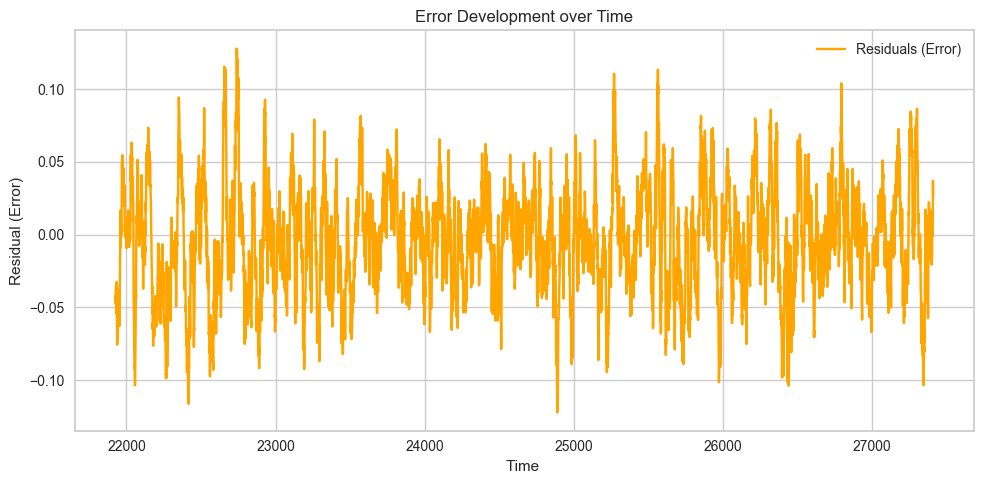

Lightgmb regression
  Metric       Value
0    MSE    0.001352
1    MAE    0.029091
2   RMSE    0.036767
3     R2    0.193647
4   MAPE    5.659050
5  SMAPE    5.586346
6    SAE  159.506050


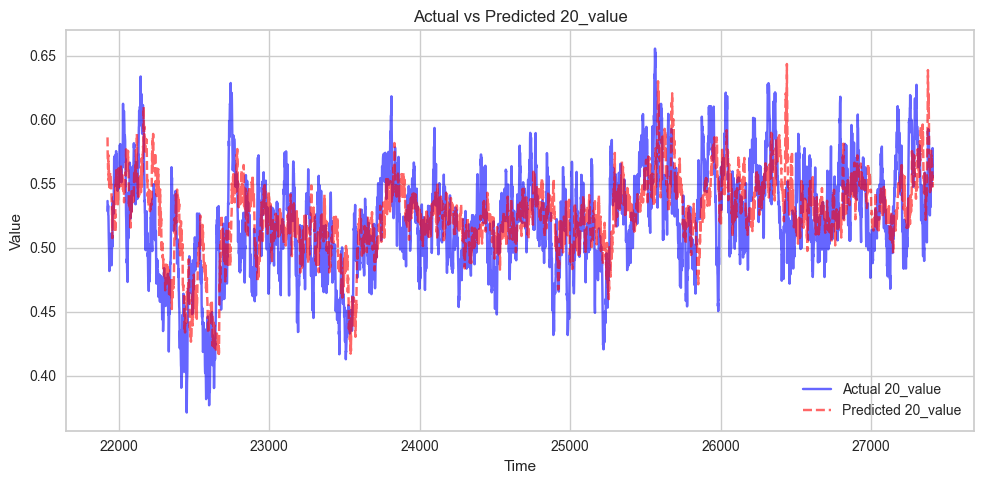

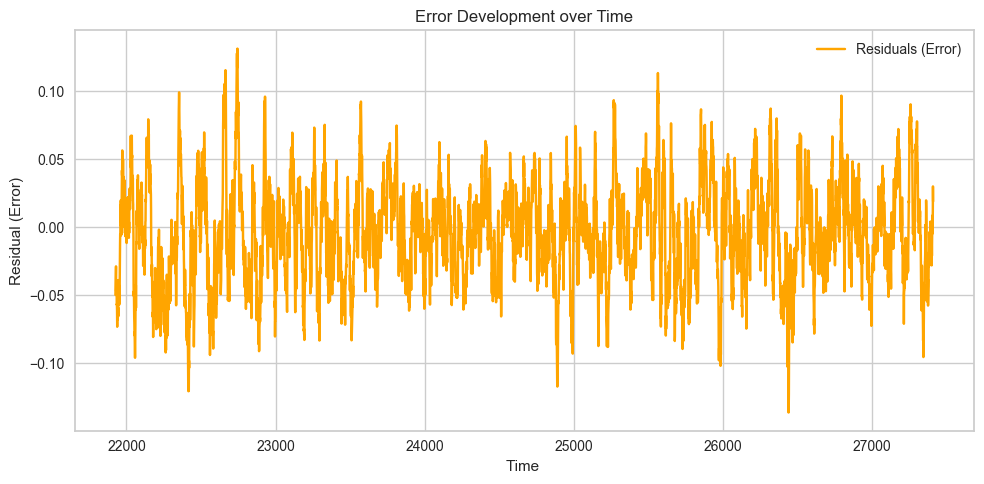

,Metric,Value
0,MSE,0.001352
1,MAE,0.029091
2,RMSE,0.036767
3,R2,0.193647
4,MAPE,5.659050
5,SMAPE,5.586346
6,SAE,159.506050


In [ ]:
from evaluation import evalresu as er
lr_pred=regression_results[regression_results.columns[0]]
rr_pred=regression_results[regression_results.columns[1]]
lgmb_pred=regression_results[regression_results.columns[2]]
rf_pred=regression_results[regression_results.columns[3]]
y_true=regression_results[regression_results.columns[4]]
print('Ridge regression')
er.evaluate_n_values(y_true,rr_pred,20)
print('Linear regression')

er.evaluate_n_values(y_true,lr_pred,20)
print('Random Forest regression')

er.evaluate_n_values(y_true,rf_pred,20)
print('Lightgmb regression')

er.evaluate_n_values(y_true,lgmb_pred,20)





  Metric       Value
0    MSE    0.001975
1    MAE    0.035379
2   RMSE    0.044440
3     R2    0.128357
4   MAPE         inf
5  SMAPE   50.167947
6    SAE  190.517083


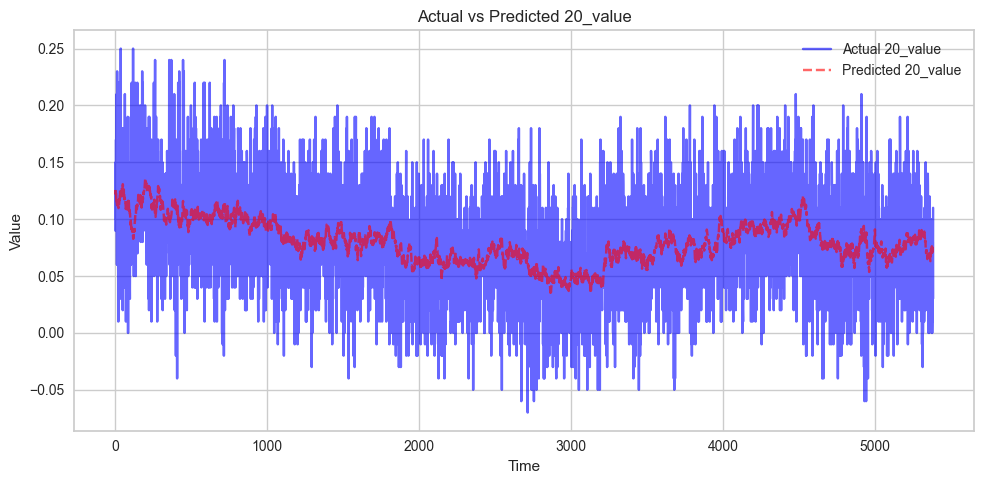

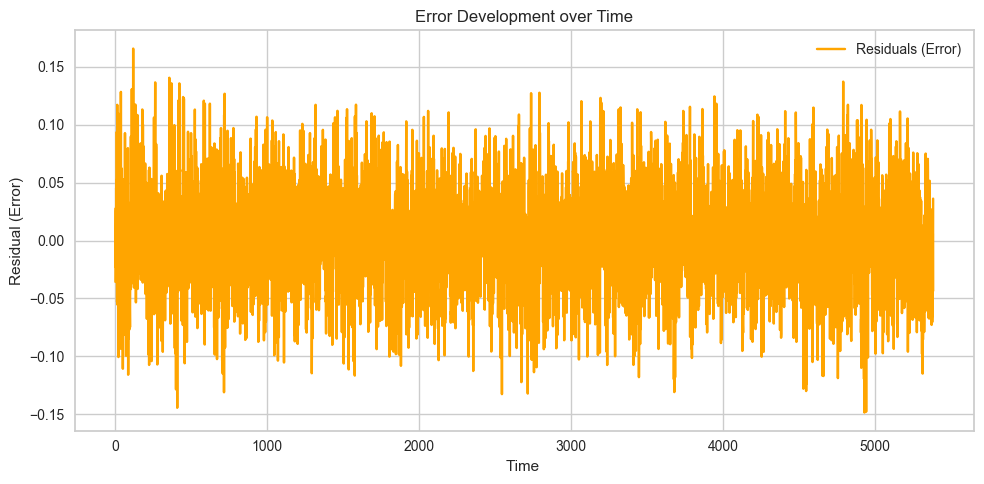

,Metric,Value
0,MSE,0.001975
1,MAE,0.035379
2,RMSE,0.044440
3,R2,0.128357
4,MAPE,inf
5,SMAPE,50.167947
6,SAE,190.517083


In [57]:
trained_model_reg=regression.get_trained_models()
from autoregression.utils_ar import prepare_direct_lstm_data 


n_past_values=100
n_future_values=20
input_shape=(n_past_values,1)

X_train_dir, y_train_dir,X_val_dir,y_val_dir,X_test_or,y_test_or = prepare_direct_lstm_data(inclination_toBD_original,n_past_values,n_future_values)
X_train_dir, y_train_dir,X_val_dir,y_val_dir,X_test_rts,y_test_rts = prepare_direct_lstm_data(inclination_toBD_sc_RTS,n_past_values,n_future_values)
y_pred=trained_model_reg[0].predict(X_test_rts.squeeze(axis=-1)).reshape(-1,1).flatten()
y_true=y_test_or[:,-1]
er.evaluate_n_values(y_true,y_pred,20)

Auto-regression

general setting, import 

In [ ]:
from evaluation import evalresu as er
import importlib
from tensorflow.keras.models import load_model
import utils.paths
importlib.reload(utils.paths)
from utils.paths import LSTM_MODELS_DIR



#data=inclination_toBD_sc_tr_sm

Models 

Model: "Direct_LSTM_Model_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,422 (810.25 KB)

 Trainable params: 69,140 (270.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 138,282 (540.17 KB)

Model: "Avarege_Direct_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 512)       │       528,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,660,734 (13.96 MB)

 Trainable params: 1,220,244 (4.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,440,490 (9.31 MB)

Model: "Advanced_Direct_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidir_lstm_1 (Bidirectional)    │ (None, 100, 128)       │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,038 (699.37 KB)

 Trainable params: 59,572 (232.70 KB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 119,146 (465.42 KB)

Model: "Refinement_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ refinement_input (InputLayer)   │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ refinement_lstm (LSTM)          │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ refined_20th_output (Dense)     │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,885 (198.77 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,924 (132.52 KB)

Model: "Seq2Seq_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm (LSTM)             │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm (LSTM)             │ (None, 20, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_output         │ (None, 20, 1)          │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,117 (148.90 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,412 (99.27 KB)

Model: "Recursive_LSTM_Model_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,885 (198.77 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,924 (132.52 KB)

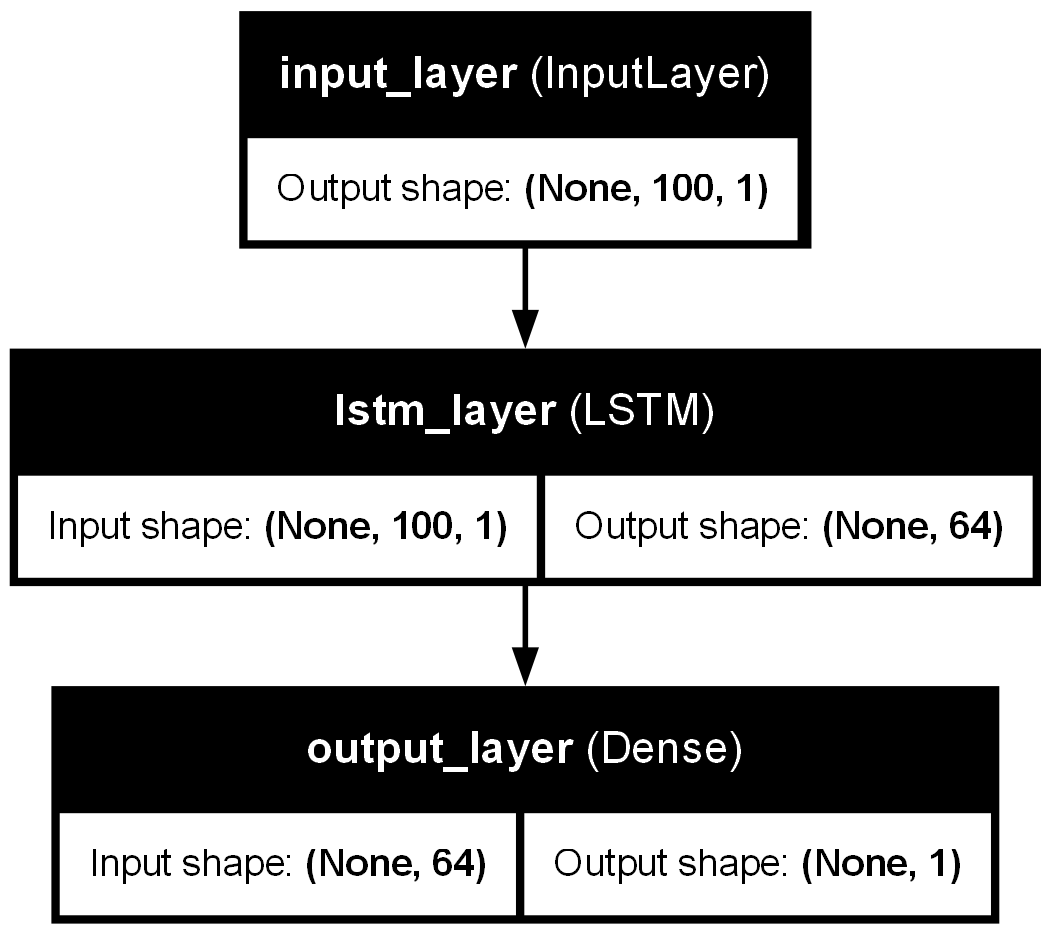

In [3]:
import mlflow.keras
from utils.paths import ML_FLOW_DIR
from tensorflow.keras.utils import plot_model


mlflow.set_tracking_uri(ML_FLOW_DIR)

direct_simple_model = mlflow.keras.load_model(f"models:/Direct_LSTM_Model_simple/7")
direct_simple_model.summary()
plot_model(direct_simple_model, to_file="export/png/direct_lstm/simple_architecture.png",show_shapes=True, show_layer_names=True)

direct_average_model = mlflow.keras.load_model(f"models:/Direct_LSTM_Model_average/6")
direct_average_model.summary()
plot_model(direct_average_model, to_file="export/png/direct_lstm/average_architecture.png",show_shapes=True, show_layer_names=True)

direct_advanced_model = mlflow.keras.load_model(f"models:/Direct_LSTM_Model_advanced/4")
direct_advanced_model.summary()
plot_model(direct_advanced_model, to_file="export/png/direct_lstm/advanced_architecture.png",show_shapes=True, show_layer_names=True)

# plot and save to file

refiner_simple_model=mlflow.keras.load_model(f"models:/Direct_Refiner_Model_simple_lstm_simple/4")
refiner_simple_model.summary()
plot_model(refiner_simple_model, to_file="export/png/hybrid_model/lstm_simple_architecture.png", show_shapes=True, show_layer_names=True)

seq2seq_simple_model=mlflow.keras.load_model(f"models:/Seq2seq_LSTM_Model_simple/4")
seq2seq_simple_model.summary()
plot_model(seq2seq_simple_model, to_file="export/png/seq2seq_lstm/simple_architecture.png", show_shapes=True, show_layer_names=True)

recursive_simple_model=mlflow.keras.load_model(f"models:/Recursive_LSTM_Model_simple/2")
recursive_simple_model.summary()
plot_model(recursive_simple_model, to_file="export/png/recursive_lstm/simple_architecture.png", show_shapes=True, show_layer_names=True)



In [ ]:
from tensorflow.keras.utils import plot_model
# plot and save to file
plot_model(model_dir_simple_trained, to_file="export/png/model_dir_simple_architecture.png", show_shapes=True, show_layer_names=True)
